# OSG GAN : Learning The Normal Distribution 

We learn to map uniform noise to a normal distribution with specified parameters using a Generative Adversarial Network


In [1]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torch.distributions.normal import Normal
import numpy

import seaborn as sns # To plot graphs

# Setup

In [2]:
#define learningrate and parameters of distribution we want to approximate
lr = 0.001
mu = 5.0
sigma = 1.0

In [3]:
g_input_size = 256 #generator input size
g_out = 256  #generator output size
d_input_size = g_out #output og g goes to d
batch_size = 50

# Dicriminator Network

In [4]:
class Discriminator(torch.nn.Module):
    #Input : vector of size d_input_size
    #Output : Probability(from Normal Distribution)
    def __init__(self,d_input_size):
        super(Discriminator,self).__init__()
        
        # 4 linear layers with relu and dropout
        self.input = nn.Sequential(
            nn.Linear(d_input_size,64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden1 = nn.Sequential(
            nn.Linear(64,32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
                
        self.hidden2 = nn.Sequential(
            nn.Linear(32,16),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.out = nn.Sequential(
            nn.Linear(16,1),
            nn.Sigmoid()
        )
             
    def forward(self,x):
        x = self.input(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
    

# Generator Network

In [5]:
class Generator(torch.nn.Module):
    #Input:  sampled from U(0,1)
    #Output gaol =  from N(0,1)
    
    
    def __init__(self,g_input_size,g_out):
        super(Generator,self).__init__()
        
        self.input = nn.Sequential(
            nn.Linear(g_input_size,128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3)
        )
        
        self.hidden1 = nn.Sequential(
            nn.Linear(128,64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3)
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(64,64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3)
        )
        
        self.out = nn.Sequential(
            nn.Linear(64,g_out)
        )
        
        
    def forward(self,x):
        x = self.input(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    

# Useful functions

In [6]:
#generates m by n matrix of uniform noise
def generate_noise(m,n):
    return Variable(torch.rand(m,n))

#generates m by n matrix of normal distribution with right parameters
def generate_real_data(m,n):
    dist = Normal( mu, sigma )
    return Variable(dist.sample( (m, n) ))


In [7]:
#targets
def real_targs(m):
    return Variable(torch.ones(m,1))

def fake_targs(m):
    return Variable(torch.zeros(m,1))

# Update functions

In [8]:
#initialise networks
discriminator = Discriminator(d_input_size)
generator = Generator(g_input_size,g_out)

#define optimisers and loss
optimiser_g = optim.Adam(generator.parameters(), 10*lr)
optimiser_d = optim.Adam(discriminator.parameters(), lr)
loss = torch.nn.BCELoss()

Here we pass data through networks as matrices

In [9]:
#this generates fake_data from the generator internally
def update_discriminator(optimiser, real_data):
    #reset gradient
    optimiser.zero_grad()

    #real targets, i.e ones
    real_targets = real_targs(batch_size)
    
    #pass through discriminator (as matrix)
    real_decision = discriminator(real_data)
    #compute loss and gradient
    real_outs = loss(real_decision,real_targets)
    real_outs.backward()
    
    #generate fake_data
    fake_data = generator(generate_noise(batch_size,g_input_size))
    #fake targets (0's)
    fake_targets = fake_targs(batch_size)
    fake_decision = discriminator(fake_data)
    #compute loss
    fake_outs = loss(fake_decision,fake_targets)
    fake_outs.backward()
    
    #take step from gradients
    optimiser.step()
    
    return (real_outs,fake_outs)

In [10]:
#generates fake data internally
def update_generator(optimiser):
    #reset gradient
    optimiser.zero_grad()
    
    #generate new fake data from noise
    fake_data = generator(generate_noise(batch_size,g_input_size))
    
    prediction = discriminator(fake_data)
    error = loss(prediction,real_targs(batch_size))
    error.backward()
    optimiser.step()
    
    return error

In [11]:
n_epoch = 10000

In [24]:
for epoch in range(n_epoch):
    #generate real_data
    real_data = generate_real_data(batch_size,d_input_size)
    
    #train discriminator
    (real_error,fake_error) = update_discriminator(optimiser_d,real_data)
    
    #train generator 

    gen_error = update_generator(optimiser_g)
    
    if epoch % 1000 == 0:
        print("epoch: " +str(epoch)+" out of " + str(n_epoch))
        print(float(real_error),float(fake_error))
        print(float(gen_error))
        print()
        

epoch: 0 out of 10000
0.6865264773368835 0.6970989108085632
0.6941934823989868

epoch: 1000 out of 10000
0.7370874285697937 0.6501592397689819
0.7350486516952515

epoch: 2000 out of 10000
0.6937710642814636 0.6932350397109985
0.6917651295661926

epoch: 3000 out of 10000
0.6954590678215027 0.6905832886695862
0.7008688449859619

epoch: 4000 out of 10000
0.6827781200408936 0.7217331528663635
0.6769384741783142

epoch: 5000 out of 10000
0.6896242499351501 0.690208375453949
0.6973291635513306

epoch: 6000 out of 10000
0.6830329298973083 0.7020915746688843
0.6852150559425354

epoch: 7000 out of 10000
0.6904959678649902 0.6968648433685303
0.6979522705078125

epoch: 8000 out of 10000
0.549629271030426 0.9026762247085571
0.6074129343032837

epoch: 9000 out of 10000
0.7273856997489929 0.6520810723304749
0.7446629405021667



# Results

In [13]:
def test_discriminator():
    
    count = 0
    count2=0
    
    real_data = [torch.randn(d_input_size) for i in range(500)]
    for i in range(500):
        d = float(discriminator(real_data[i]))
        if d >= 0.5:
            count += 1

            
    fake_data = [generator(torch.rand(d_input_size)) for i in range(500)]
    for i in range(500):
        if float(discriminator(fake_data[i])) < 0.5:
            count2 += 1

    print("recognises real data " + str(count/5) + "% of the time")
    print("recognises fake data " + str(count2/5) + "% of the time")
    

In [14]:
test_discriminator()

recognises real data 0.2% of the time
recognises fake data 27.0% of the time


In [15]:
def test_generator():
    count = 0
    fake_data = [generator(torch.rand(g_input_size)) for i in range(500)]
    for i in range(500):
        g = float(discriminator(fake_data[i]))
        if g > 0.5:
            count+=1

    print("fools the discriminator " + str(count/5) + "% of the time")

In [16]:
test_generator()

fools the discriminator 65.4% of the time


In [17]:
def show():
    x = generator(torch.rand(g_input_size)).detach().numpy()
    print(numpy.average(x))
    sns.distplot(x) # Produces a pdf estimate for the generator's values

5.081173


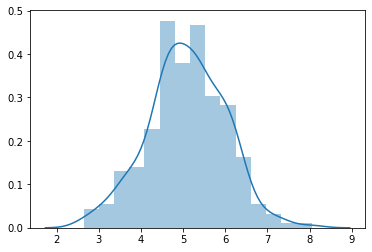

In [31]:
show()

5.0990005


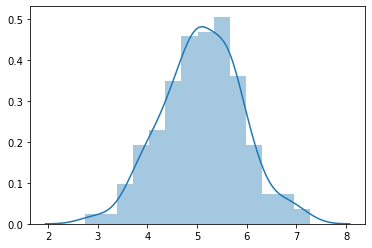

In [30]:
show()

In [20]:
def target():
    x = generate_real_data(g_out,1)
    sns.distplot(x)
    

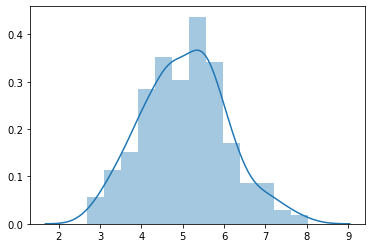

In [26]:
target()